# GANによる画像生成のメカニズムとDCGANの実装

commit用

```mycode/5_gan_generation/```

In [1]:
!pip list | grep scikit

scikit-image                      0.16.2             
scikit-learn                      0.22.2.post1       


In [41]:
!gpustat

s2                   Tue Apr 14 21:19:25 2020  440.44
[0] Quadro RTX 8000  | 27'C,   0 % |   745 / 48601 MB | kera(733M)
[1] Quadro RTX 8000  | 26'C,   0 % |    12 / 48601 MB |
[2] Quadro RTX 8000  | 35'C,   0 % |  1195 / 48601 MB | hasegawa(1183M)
[3] Quadro RTX 8000  | 64'C, 100 % | 22401 / 48601 MB | taoli(22385M)
[4] Quadro RTX 8000  | 62'C,  94 % |  8859 / 48601 MB | hara(8847M)
[5] Quadro RTX 8000  | 60'C,  83 % |  5811 / 48601 MB | taoli(5797M)
[6] Quadro RTX 8000  | 63'C, 100 % | 16864 / 48601 MB | taoli(10587M) taoli(6259M)
[7] Quadro RTX 8000  | 61'C,  90 % |  5351 / 48601 MB | taoli(5337M)


In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
%config IPCompleter.greedy=True

## 5-1 GANによる画像生成のメカニズムとDCGANの実装

### Generatorのメカニズム
Generatorは入力乱数から目的の画像を生成するのでデータの次元を拡大していく必要がある．
このときに重要になるのが**転置畳み込み**である．
普通の畳み込みは入力データの全てのセルとカーネルの全てのセルの計算結果を集約して１つのセルにするのに対して，転置畳み込みは１つの入力セルに対して全てのカーネルのセルを作用させてその１つ１つを出力とするので結果として出力されるデータの次元は大きくなる．

### Generatorの実装
本節ではGANの中でも特に**DCGAN**と呼ばれるものを実装する．

***DCGAN：***Deep Convolution Generative Adversarial Network

実装に当たって入力する乱数の次元を```z_dim=20```にしてるがこれには特に意味はなく，生成画像の多様性が担保されればなんでも良い


In [9]:
class Generator(nn.Module):
    
    def __init__(self, z_dim = 20, image_size=64):
        super(Generator, self).__init__()
        
        # ここで out_channels = image_size*8に特別な意味は？
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
            
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
              
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 白黒なので出力は1チャネル
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

torch.Size([1, 20, 1, 1])
--------------------
torch.Size([1, 1, 64, 64])


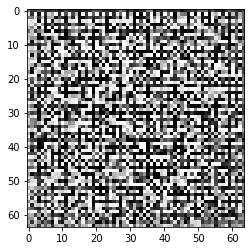

In [10]:
# 実装したネットワークで出力
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1,20)

# テンソルを(1,20)から(1,20,1,1)に変形
# (batch_size, channel, H, W)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
print(input_z.size())

print("--------------------")

fake_images = G(input_z)
print(fake_images.size())

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

### Discirminatorのメカニズム
Generatorの生成する画像に対して損失関数を定義する必要がある．
この損失関数を人間の手によってラベルをつけることによって行うことはほぼ無理である．主な理由は
1. 膨大な量の画像に対してラベルをつけることは効率でない
2. 初期のGeneratorは学習していないのであまりに精度高くラベル付けをしてしまうと全てが目的の画像に見えないと分類されてしまうので学習が進まない

そこで**Discriminator**を判定機として作成することで，DiscriminatorもGeneratorと同レベルなので適度にラベル付けを行うことができる．

### Discriminatorの実装
**GANのDiscriminatorではLeakyReLUを用いることに注意する**

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [12]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

# 偽画像の生成
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力に対してシグモイドをかけて[0,1]に限定
print(nn.Sigmoid()(d_out))

tensor([[[[0.4978]]]], grad_fn=<SigmoidBackward>)


## 5-2 DCGANの損失関数，学習，生成の実装
本節ではDCGANの損失関数の実装する

###  GANの損失関数
詳しくは ```Jensen-Shannonダイバージェンス``` というクラス分類問題であるがここでは簡略化する

入力される画像データを$x$とするとき，出力$y$は$y=D(x)$で表現される．
ここで$y$は教師画像である確率を表している．
よってあるラベル$l$に対する損失は$y^l(1-y)^{1-l}$で計算される．教師ラベルを1,偽画像を０とする．ミニバッチがM個あるので同時確率は
$$
\Pi_{i=1}^M {y_i}^{l_i}(1-y_i)^{1-l_i}
$$
となるのでこれに対数をとる．
またこのままでは最大化問題になるのでマイナスをとることで最小化問題に変える．
$$
-\sum_{i=1}^M[l_i\log y_i + (1-l_i)\log(1-y_i)]
$$
これがDのニューラルネットワークの損失関数となる．

この損失関数は```torch.nn.BCEWithLogitsLoss()```を使用して実装する．

In [10]:
# Dの誤差関数のイメージ実装
# ただしこのセルはxが未定義なのでエラーとなる
# print("------------------------------")

# # 正解ラベル
# mini_batch_size = 2
# label_real = torch.full((mini_batch_size,),1)
# print(label_real)

# # 偽ラベル
# label_fake = torch.full((mini_batch_size,),0)

# # 誤差関数を定義
# criterion = nn.BCEWithLogitsLoss(reduction="mean")

# # 真の画像を判定
# d_out_real = D(x)

# # 偽の画像を生成して判定
# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
# fake_images = G(input_z)
# d_out_fake = D(input_z)

# # 誤差の計算
# d_loss_real = criterion(d_out_real.view(-1), label_real)
# d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
# d_loss = d_loss_real + d_loss_fake

次にGの損失関数の実装をする．
ここでGはDを騙すことを目標とするのでDの損失関数が大きくなることが目標となる．

したがって損失関数は
$$
\sum_{i=1}^M[l_i\log y_i + (1-l_i)\log(1-y_i)]
$$
とすることができる．ただしここでGは偽画像の中でどれだけ騙すことができたかについて考えるので，この式の第一項は常に0となる．また同様の理由で$(1-l_i)=1$となる．よって損失関数は次のようになる．
$$
\sum_{i=1}^M\log(1-D(G(z_i)))
$$
しかしこのままでは学習の開始時点でもほとんどの生成した偽画像がほぼ未学習のDであっても見破られてしまうので損失関数がほぼゼロになってしまう(本来騙せたとしたらマイナスになっていく最小化問題である)

そこで見破られたら大きな正で騙せたら０に近づいていく最小化問題に問題を置き換えることによって学習が進むようにする．
$$
-\sum_{i=1}^M\log D(G(z_i))
$$

またこの部分は実装では
```criterion(d_out_fake.view(-1), label_real)```としているがこれは偽画像から作られたものに対する，本物であるという確信度を教師ラベルを用いて誤差関数を求めてることによって実際には偽画像によって得られ確信度がどれだけリアル

注意する点としてはd_out_fakeはそれ自体ではシグモイドをまだかけられていないので[0,1]の範囲内にある値ではない点である

In [11]:
# mini_batch_size = 3
# def sigmoid(a):
#     s = 1 / (1 + math.e**-a)
#     return s

# # d = torch.full((mini_batch_size,), 0.1) #tensor(0.7444) #0.6444
# d = torch.Tensor([0.5,0.5,0.5]) #0.9741      #0.4741
# # d = torch.full((mini_batch_size,), 0.9) #tensor(1.2412) #0.3412
# print(d)

# label = torch.full((mini_batch_size,),1)
# label = torch.full((mini_batch_size,),0)
# print(label)

# criterion = nn.BCEWithLogitsLoss(reduction="mean")
# print(criterion(d.view(-1), label))

In [15]:
# input_z = torch.randn(mini_batch_size, 20)
# input_z = input_z.view(input_z.size(0), input_z.size(1), 1,1)
# fake_images = G(input_z)
# d_out_fake = D(fake_images)

# # 誤差の計算
# g_loss = criterion(d_out_fake.view(-1), label_real) #ここはlabel_realを用いることに注意

### DataLoaderの作成
基本的には今までとやることは同じだがデータセットを学習と検証に分ける必要がない．
おそらくこれは精度など定量的な評価が必要なわけではなく，定性的な評価で十分なので分ける必要がないのだと思う．

In [14]:
def make_datapath_list():
    
    train_img_list = list()
    
    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
        img_path = "./data/img_78/img_8_" + str(img_idx) + ".jpg"
        train_img_list.append(img_path)
        
    return train_img_list


class ImageTransform():
    """
    画像クラスの前処理
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)
    

class GAN_Img_Dataset(data.Dataset):
    """
    画像のDataset
    """
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
            
    def __len__(self):
        """画像の枚数を返す"""
        return len(self.file_list)
    
    def __getitem__(self,index):
        """前処理をした画像のTensor形式のデータを取得"""
        
        img_path = self.file_list[index]
        img = Image.open(img_path) #H,W,C
        
        # 前処理
        img_transformed = self.transform(img)
        
        return img_transformed

In [16]:
# DataLoaderの作成
train_img_list = make_datapath_list()
# print(train_img_list)

# Datasetの作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(train_img_list, ImageTransform(mean, std))

# DataLoaderの作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = batch_size, shuffle=True)


torch.Size([64, 1, 64, 64])


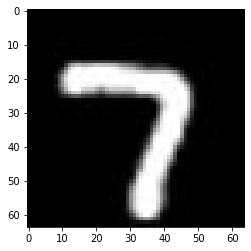

In [17]:
#動作確認
batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())
img_transformed = imges[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

### DCGANの学習
DCGANではそれぞれの初期化のパラメータは理論的な導出があるわけではなく経験的にこれがうまくいくのでこれを採用する．

バックプロパゲーションはG,Dそれぞれ別々に行われるが，それぞれの場合でどちらも初期化している．これはおそらくGのバックプロパゲーションにはDの出力を含むのでDの逆伝搬の値が影響する．よってDの学習で用いられた逆伝搬までGの学習まで波及する．これはDの学習についても同様である．

また，これはDのネットワークにReLUではなくLeakyReLUを用いた理由にも繋がり，Dでの逆伝搬はGにも波及するが，DにReLUを用いると多くのパラメータが0となってしまいGの学習が進まない結果となってしまう．

In [18]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02) # mean  = 0.0 , std = 0.02
        nn.init.constant_(m.bias.data,0)
    elif classname.find("BatchNorm") != -1:
        #BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data,0)
        
# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("nextットワークの初期化完了")

nextットワークの初期化完了


In [19]:
# モデルを学習させる関数の作成
def train_model(G,D,dataloader, num_epochs):
    
    # GPU環境の確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス : ", device)
    
    # 最適化手法の設定
    g_lr, d_lr = 0.00001, 0.00004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2] )
    d_optimizer = torch.optim.Adam(D.parameters(), g_lr, [beta1, beta2] )
    
    
    # 誤差関数の定義
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    # パラメータ
    z_dim = 20
    mini_batch_size = 64
    
    # GPU
    G.to(device)
    D.to(device)
    
    G.train()
    D.train()
    
    # 高速化
    torch.backends.cudnn.benchmark = True
    
    # 画像枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    
    # epochのループ
    for epoch in range(num_epochs):
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print("-----------------------------------")
        print("Epoch {}/{} ".format(epoch, num_epochs))
        print("-----------------------------------")
        print("---  (train)  ---")
        
        # データローダからmini_batchずつ取り出す
        for imges in dataloader:
            
            
            """
            
            1.　Disicriminatorの学習
            
            """
            # ミニバッチがサイズが1だと，バッチノーマライゼーションでエラーになるので避ける
            if imges.size()[0] == 1:
                continue
                
            # GPUが使えるなら使う
            imges = imges.to(device)
            
            # 　正解ラベルと偽ラベルを作成
            # 最後のepochだけはミニバッチの余りなので数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,),1).to(device)
            label_fake = torch.full((mini_batch_size,),0).to(device)
            
            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1), 1,1 )
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            
            # 誤差の計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # backward()
            g_optimizer.zero_grad()  # ここでどちらも初期化すること！
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
        

            """
            
            2.　Generatorの学習
            
            """
            
            # 偽画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1), 1,1 )
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            # 誤差の計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # backward()
            g_optimizer.zero_grad()  # ここでどちらも初期化すること！
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            

            """
            
            3.　記録
            
            """
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print("----------------------------")
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        if ((epoch+1)%20==0):
            torch.save(G.state_dict(), "weights/dcgan_g_"+str(epoch+1) + ".pth")
            torch.save(D.state_dict(), "weights/dcgan_d_"+str(epoch+1) + ".pth")

    return G, D

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス : ", device)

使用デバイス :  cuda:0


In [39]:
# 学習・検証を実行
num_epochs = 200
G_update, D_update = train_model(
    G,D,dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス :  cuda:0
-----------------------------------
Epoch 0/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 0 || Epoch_D_Loss:0.0846 ||Epoch_G_Loss:0.1466
timer:  0.6299 sec.
-----------------------------------
Epoch 1/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 1 || Epoch_D_Loss:0.0867 ||Epoch_G_Loss:0.1720
timer:  0.4729 sec.
-----------------------------------
Epoch 2/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 2 || Epoch_D_Loss:0.0830 ||Epoch_G_Loss:0.1511
timer:  0.3796 sec.
-----------------------------------
Epoch 3/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 3 || Epoch_D_Loss:0.0857 ||Epoch_G_Loss:0.1713
timer:  0.4733 sec.
-----------------------------------
Epoch 4/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 4 || Epoch_D_Loss:0.0898 

----------------------------
epoch 40 || Epoch_D_Loss:0.1383 ||Epoch_G_Loss:0.1059
timer:  0.4031 sec.
-----------------------------------
Epoch 41/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 41 || Epoch_D_Loss:0.1409 ||Epoch_G_Loss:0.1209
timer:  0.3087 sec.
-----------------------------------
Epoch 42/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 42 || Epoch_D_Loss:0.1458 ||Epoch_G_Loss:0.1051
timer:  0.4115 sec.
-----------------------------------
Epoch 43/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 43 || Epoch_D_Loss:0.1404 ||Epoch_G_Loss:0.1190
timer:  0.3918 sec.
-----------------------------------
Epoch 44/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 44 || Epoch_D_Loss:0.1485 ||Epoch_G_Loss:0.1003
timer:  0.3195 sec.
-----------------------------------
Epoch 45/200 
-------------------

----------------------------
epoch 80 || Epoch_D_Loss:0.1389 ||Epoch_G_Loss:0.1000
timer:  0.5062 sec.
-----------------------------------
Epoch 81/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 81 || Epoch_D_Loss:0.1428 ||Epoch_G_Loss:0.1207
timer:  0.4533 sec.
-----------------------------------
Epoch 82/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 82 || Epoch_D_Loss:0.1430 ||Epoch_G_Loss:0.0974
timer:  0.4096 sec.
-----------------------------------
Epoch 83/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 83 || Epoch_D_Loss:0.1434 ||Epoch_G_Loss:0.1195
timer:  0.4740 sec.
-----------------------------------
Epoch 84/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 84 || Epoch_D_Loss:0.1352 ||Epoch_G_Loss:0.1020
timer:  0.3233 sec.
-----------------------------------
Epoch 85/200 
-------------------

----------------------------
epoch 120 || Epoch_D_Loss:0.1699 ||Epoch_G_Loss:0.0869
timer:  0.3370 sec.
-----------------------------------
Epoch 121/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 121 || Epoch_D_Loss:0.1683 ||Epoch_G_Loss:0.1020
timer:  0.3407 sec.
-----------------------------------
Epoch 122/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 122 || Epoch_D_Loss:0.1654 ||Epoch_G_Loss:0.0850
timer:  0.3271 sec.
-----------------------------------
Epoch 123/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 123 || Epoch_D_Loss:0.1701 ||Epoch_G_Loss:0.1034
timer:  0.2960 sec.
-----------------------------------
Epoch 124/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 124 || Epoch_D_Loss:0.1622 ||Epoch_G_Loss:0.0871
timer:  0.3256 sec.
-----------------------------------
Epoch 125/200 
---------

----------------------------
epoch 160 || Epoch_D_Loss:0.1486 ||Epoch_G_Loss:0.0934
timer:  0.5882 sec.
-----------------------------------
Epoch 161/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 161 || Epoch_D_Loss:0.1531 ||Epoch_G_Loss:0.1070
timer:  0.4552 sec.
-----------------------------------
Epoch 162/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 162 || Epoch_D_Loss:0.1507 ||Epoch_G_Loss:0.1011
timer:  0.5106 sec.
-----------------------------------
Epoch 163/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 163 || Epoch_D_Loss:0.1490 ||Epoch_G_Loss:0.1126
timer:  0.6354 sec.
-----------------------------------
Epoch 164/200 
-----------------------------------
---  (train)  ---
----------------------------
epoch 164 || Epoch_D_Loss:0.1459 ||Epoch_G_Loss:0.0947
timer:  0.4861 sec.
-----------------------------------
Epoch 165/200 
---------

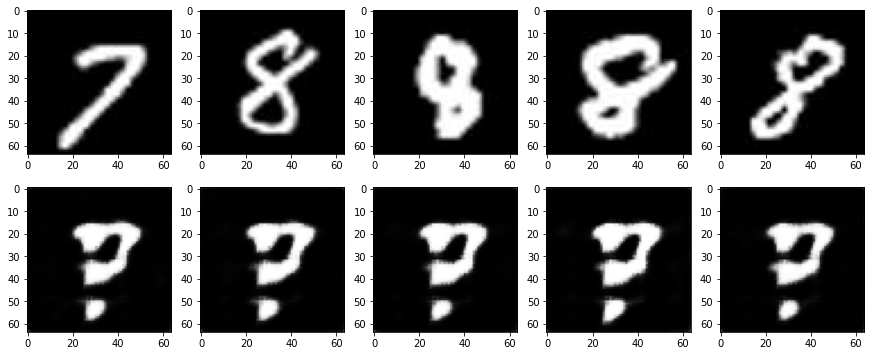

In [40]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')